
# Example of High Gamma Filter

Below is a code sample for extracting high gamma power from a raw data file, followed by permutation cluster stats on that high gamma power data


In [9]:
import ieeg.viz.utils
from ieeg.navigate import channel_outlier_marker, trial_ieeg, crop_empty_data, outliers_to_nan
from ieeg.io import raw_from_layout, get_data
from ieeg.timefreq.utils import crop_pad
from ieeg.calc import stats, scaling
from ieeg.process import parallelize
from ieeg.timefreq import gamma
from ieeg.calc.scaling import rescale

import matplotlib.pyplot as plt

from bids import BIDSLayout
import mne
import os
import numpy as np

import pickle

### grab the data and set up variables

In [10]:
HOME = os.path.expanduser("~")

# get box directory depending on OS
if os.name == 'nt': # windows
    LAB_root = os.path.join(HOME, "Box", "CoganLab")
else: # mac
    LAB_root = os.path.join(HOME, "Library", "CloudStorage", "Box-Box", "CoganLab")

layout = get_data("GlobalLocal", root=LAB_root)



print(layout.derivatives)
print(layout.derivatives.keys())

# raw = raw_from_layout(layout, subject=sub,
#                         extension='.edf', preload=True)
subjects = layout.get(return_type="id", target="subject")
sub = "D0057" #just do one at a time for now, can implement all in a for loop later
print(subjects)


filt = raw_from_layout(layout.derivatives['derivatives/clean'], subject=sub,
                           extension='.edf', desc='clean', preload=False) #get line-noise filtered data



save_dir = os.path.join(layout.root, 'derivatives', 'freqFilt', sub)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)



# # what to call the folder, is there a convention? Nahhh.

{'derivatives/clean': BIDS Layout: ...alLocal\BIDS\derivatives\clean | Subjects: 6 | Sessions: 0 | Runs: 24}
KeysView({'derivatives/clean': BIDS Layout: ...alLocal\BIDS\derivatives\clean | Subjects: 6 | Sessions: 0 | Runs: 24})
['D0057', 'D0059', 'D0063', 'D0065', 'D0069', 'D0071', 'D0077']
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-01_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-01_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-01_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivativ

c:\Users\jz421\Desktop\GlobalLocal\ieeg\io.py:100: RuntimeWarning: The number of channels in the channels.tsv sidecar file (179) does not match the number of channels in the raw data file (178). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path)
c:\Users\jz421\Desktop\GlobalLocal\ieeg\io.py:100: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-02_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-02_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-03_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\Users\jz421\Desktop\GlobalLocal\ieeg\io.py:100: RuntimeWarning: Omitted 228 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path)
c:\Users\jz421\Desktop\GlobalLocal\ieeg\io.py:100: RuntimeWarning: The number of channels in the channels.tsv sidecar file (179) does not match the number of channels in the raw data file (178). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path)
c:\Users\jz421\Desktop\GlobalLocal\ieeg\io.py:100: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-03_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-03_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_acq-01_space-ACPC_electrodes.tsv.
Extracting EDF parameters from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-04_desc-clean_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\Users\jz421\Desktop\GlobalLocal\ieeg\io.py:100: RuntimeWarning: Omitted 228 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path)
c:\Users\jz421\Desktop\GlobalLocal\ieeg\io.py:100: RuntimeWarning: The number of channels in the channels.tsv sidecar file (179) does not match the number of channels in the raw data file (178). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path)
c:\Users\jz421\Desktop\GlobalLocal\ieeg\io.py:100: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path)


Reading events from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-04_desc-clean_events.tsv.
Reading channel info from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_task-GlobalLocal_acq-01_run-04_desc-clean_channels.tsv.
Reading electrode coords from C:\Users\jz421\Box\CoganLab\BIDS-1.1_GlobalLocal\BIDS\derivatives\clean\sub-D0057\ieeg\sub-D0057_acq-01_space-ACPC_electrodes.tsv.


c:\Users\jz421\Desktop\GlobalLocal\ieeg\io.py:100: RuntimeWarning: Omitted 226 annotation(s) that were outside data range.
  new_raw = read_raw_bids(bids_path=BIDS_path)
c:\Users\jz421\Desktop\GlobalLocal\ieeg\io.py:100: RuntimeWarning: The number of channels in the channels.tsv sidecar file (179) does not match the number of channels in the raw data file (178). Will not try to set channel names.
  new_raw = read_raw_bids(bids_path=BIDS_path)
c:\Users\jz421\Desktop\GlobalLocal\ieeg\io.py:100: RuntimeWarning: Cannot set channel type for the following channels, as they are missing in the raw data: Trigger
  new_raw = read_raw_bids(bids_path=BIDS_path)


### Okay now actually do filtering

In [3]:
## Crop raw data to minimize processing time
new = crop_empty_data(filt, )

# Mark channel outliers as bad
# new.info['bads'] = channel_outlier_marker(new, 4)
# Exclude bad channels
good = new.copy().drop_channels(filt.info['bads'])
good.load_data()

# CAR
ch_type = filt.get_channel_types(only_data_chs=True)[0]
good.set_eeg_reference(ref_channels="average", ch_type=ch_type)

# Remove intermediates from mem
del new

Reading 0 ... 3219820  =      0.000 ...  1572.178 secs...
Applying average reference.
Applying a custom ('sEEG',) reference.


In [12]:
# make stimulus baseline EpochsTFR
times=[-1, 0.5]

trials = trial_ieeg(good, "Stimulus", times, preload=True)
# outliers_to_nan(trials, outliers=10)
HG_base = gamma.extract(trials, copy=False, n_jobs=1)
crop_pad(HG_base, "0.5s")

Used Annotations descriptions: ['Response/c25/n25', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/n25', 'Response/i75/n75', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s25', 'Response/i75/s75', 'Stimulus/c25/n25', 'Stimulus/c25/r25', 'Stimulus/c25/r75', 'Stimulus/c25/s25', 'Stimulus/c25/s75', 'Stimulus/c75/r25', 'Stimulus/c75/r75', 'Stimulus/c75/s25', 'Stimulus/c75/s75', 'Stimulus/i25/n75', 'Stimulus/i25/r25', 'Stimulus/i25/r75', 'Stimulus/i25/s25', 'Stimulus/i25/s75', 'Stimulus/i75/n25', 'Stimulus/i75/n75', 'Stimulus/i75/r25', 'Stimulus/i75/r75', 'Stimulus/i75/s25', 'Stimulus/i75/s75']
event_ids: {'c25/n25': 20, 'c25/r25': 21, 'c25/r75': 22, 'c25/s25': 23, 'c25/s75': 24, 'c75/r25': 25, 'c75/r75': 26, 'c75/s25': 27, 'c75/s75': 28, 'i25/n75': 29, 'i25/r25': 30, 'i25/r75': 

0 bad epochs dropped


100%|██████████| 448/448 [04:34<00:00,  1.63it/s]


In [16]:
data_dict = {}  # Create an empty dictionary

for event, t in zip(("Stimulus", "Response"), ((-1, 1.5), (-1, 1.5))):
    times = [None, None]
    times[0] = t[0] - 0.5
    times[1] = t[1] + 0.5
    trials = trial_ieeg(good, event, times, preload=True)
    # outliers_to_nan(trials, outliers=10)
    HG_ev1 = gamma.extract(trials, copy=False, n_jobs=1)
    crop_pad(HG_ev1, "0.5s")

    HG_ev1_rescaled = rescale(HG_ev1, HG_base, copy=True, mode='ratio').average(
        lambda x: np.nanmean(x, axis=0), copy=True)
    # HG_ev1.resample(100)
    # HG_ev1.filenames = good.filenames

    # Store the variable in the dictionary with the desired name
    data_dict[f"HG_ev1_{event}"] = HG_ev1
    data_dict[f"HG_ev1_{event}_rescaled"] = HG_ev1_rescaled
# Specify the file path where you want to save the dictionary
file_path = "data_dict.pickle"

# Save the dictionary to a pickle file
with open(file_path, "wb") as file:
    pickle.dump(data_dict, file)




    

Used Annotations descriptions: ['Response/c25/n25', 'Response/c25/r25', 'Response/c25/r75', 'Response/c25/s25', 'Response/c25/s75', 'Response/c75/r25', 'Response/c75/r75', 'Response/c75/s25', 'Response/c75/s75', 'Response/i25/r25', 'Response/i25/r75', 'Response/i25/s25', 'Response/i25/s75', 'Response/i75/n25', 'Response/i75/n75', 'Response/i75/r25', 'Response/i75/r75', 'Response/i75/s25', 'Response/i75/s75', 'Stimulus/c25/n25', 'Stimulus/c25/r25', 'Stimulus/c25/r75', 'Stimulus/c25/s25', 'Stimulus/c25/s75', 'Stimulus/c75/r25', 'Stimulus/c75/r75', 'Stimulus/c75/s25', 'Stimulus/c75/s75', 'Stimulus/i25/n75', 'Stimulus/i25/r25', 'Stimulus/i25/r75', 'Stimulus/i25/s25', 'Stimulus/i25/s75', 'Stimulus/i75/n25', 'Stimulus/i75/n75', 'Stimulus/i75/r25', 'Stimulus/i75/r75', 'Stimulus/i75/s25', 'Stimulus/i75/s75']
event_ids: {'c25/n25': 20, 'c25/r25': 21, 'c25/r75': 22, 'c25/s25': 23, 'c25/s75': 24, 'c75/r25': 25, 'c75/r75': 26, 'c75/s25': 27, 'c75/s75': 28, 'i25/n75': 29, 'i25/r25': 30, 'i25/r75': 

No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 448 events and 7169 original time points ...


In [9]:
# read pickle file that we saved previously

# Specify the file path where you want to save the dictionary
file_path = "data_dict.pickle"

with open(file_path, "rb") as file:
    data_dict = pickle.load(file)

In [31]:
resp_evoke = data_dict["HG_ev1_Response"].average(method=lambda x: np.nanmean(x, axis=0))
resp_evoke_rescaled = data_dict["HG_ev1_Response_rescaled"].average(method=lambda x: np.nanmean(x, axis=0))
stim_evoke = data_dict["HG_ev1_Stimulus"].average(method=lambda x: np.nanmean(x, axis=0))
stim_evoke_rescaled = data_dict["HG_ev1_Stimulus_rescaled"].average(method=lambda x: np.nanmean(x, axis=0))

# # # Manually interpolate NaN values
# resp_evoke.data = np.where(np.isnan(resp_evoke.data), np.interp(resp_evoke.times, resp_evoke.times[~np.isnan(resp_evoke.data[0])], resp_evoke.data[0, ~np.isnan(resp_evoke.data[0])]), resp_evoke.data)

# # Exclude time points with NaN values
# valid_time_points = ~np.isnan(resp_evoke.data[0])  # Filter time points without NaNs
# resp_evoke = resp_evoke.crop(tmin=resp_evoke.times[valid_time_points][0], tmax=resp_evoke.times[valid_time_points][-1])

# Plot the evoked data
fig = resp_evoke_rescaled.plot()
fig.savefig('HG_ev1_Response_rescaled.png')

fig = stim_evoke_rescaled.plot()
fig.savefig('HG_ev1_Stimulus_rescaled.png')

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


# do time permutation cluster statistics

### decimate..?

In [42]:
resp = data_dict["HG_ev1_Response_rescaled"]
stim = data_dict["HG_ev1_Stimulus_rescaled"]
base[0].decimate(2)
resp.decimate(2)
stim.decimate(2)

C:\Users\jz421\AppData\Local\Temp\ipykernel_504\3235446528.py:3: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 256.0 Hz, which can cause aliasing artifacts.
  base[0].decimate(2)
C:\Users\jz421\AppData\Local\Temp\ipykernel_504\3235446528.py:4: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 256.0 Hz, which can cause aliasing artifacts.
  resp.decimate(2)
C:\Users\jz421\AppData\Local\Temp\ipykernel_504\3235446528.py:5: RuntimeWarning: The measurement information indicates a low-pass frequency of 1024.0 Hz. The decim=2 parameter will result in a sampling frequency of 1024.0 Hz, which can cause aliasing artifacts.
  stim.decimate(2)


Number of events,448
Events,c25/n25: 1c25/r25: 63c25/r75: 23c25/s25: 20c25/s75: 61c75/r25: 24c75/r75: 11c75/s25: 4c75/s75: 17i25/n75: 1i25/r25: 21i25/r75: 5i25/s25: 7i25/s75: 22i75/n25: 1i75/n75: 1i75/r25: 60i75/r75: 17i75/s25: 23i75/s75: 66
Time range,-1.000 – 1.500 s
Baseline,off


In [21]:
# import scipy
resp_mask = stats.time_perm_cluster(resp._data, HG_base._data, 0.05, axis=0,
                               n_perm=1000, n_jobs=6, ignore_adjacency=1)


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   57.2s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:   57.3s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:   57.4s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:   57.5s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:   57.6s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   57.9s
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done  15 tasks      | elapsed:  2.9min
[Parallel(

In [43]:
stim_mask = stats.time_perm_cluster(stim._data, HG_base._data, 0.05, axis=0,
                               n_perm=1000, n_jobs=6, ignore_adjacency=1)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   56.2s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:   56.3s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:   56.4s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:   56.5s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:   56.6s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   56.7s
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done  15 tasks      | elapsed:  2.7min
[Parallel(

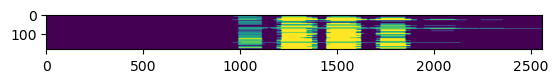

In [47]:
%matplotlib inline
plt.imshow(stim_mask)

plt.savefig('stimulus_stats.png')


In [ ]:
plt.imshow(resp_mask)
plt.savefig('response_stats.png')